Szymon Czaplak, Krzysztof Pala

In [1]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

# Load Data

Attribute Information:
   1. survival -- the number of months patient survived (has survived,
		  if patient is still alive).  Because all the patients
		  had their heart attacks at different times, it is 
		  possible that some patients have survived less than
		  one year but they are still alive.  Check the second
		  variable to confirm this.  Such patients cannot be 
		  used for the prediction task mentioned above.
   2. still-alive -- a binary variable.  0=dead at end of survival period,
		     1 means still alive 
   3. age-at-heart-attack -- age in years when heart attack occurred
   4. pericardial-effusion -- binary. Pericardial effusion is fluid
			      around the heart.  0=no fluid, 1=fluid
   5. fractional-shortening -- a measure of contracility around the heart
			       lower numbers are increasingly abnormal
   6. epss -- E-point septal separation, another measure of contractility.  
	      Larger numbers are increasingly abnormal.
   7. lvdd -- left ventricular end-diastolic dimension.  This is
	      a measure of the size of the heart at end-diastole.
	      Large hearts tend to be sick hearts.
   8. wall-motion-score -- a measure of how the segments of the left
			   ventricle are moving
   9. wall-motion-index -- equals wall-motion-score divided by number of
			   segments seen.  Usually 12-13 segments are seen
			   in an echocardiogram.  Use this variable INSTEAD
			   of the wall motion score.
   10. mult -- a derivate var which can be ignored
   11. name -- the name of the patient (I have replaced them with "name")
   12. group -- meaningless, ignore it
   13. alive-at-1 -- Boolean-valued. Derived from the first two attributes.
                     0 means patient was either dead after 1 year or had
                     been followed for less than 1 year.  1 means patient 
                     was alive at 1 year.

In [2]:
filename = "echocardiogram.csv"

In [3]:
# changed (by hand) line 50 in data - additional coma: ,?,?,77,?,?,?,?,?,2,?,name,2,?  => ?,?,77,?,?,?,?,?,2,?,name,2,?
headers = ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion',
           'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score', 
           'wall-motion-index', 'mult', 'name', 'group', 'alive-at-1']

df = pd.read_csv(filename, names=headers)

original_df = df.copy()

# Preprocessing

In [4]:
# dropping name, group, mult as they are useless in classifying problem
# dropping wall-motion-index, beacuse I will be using wall-motion-score

df = df.drop(columns=['mult', 'name', 'group', 'wall-motion-index'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 9 columns):
survival                 132 non-null object
still-alive              132 non-null object
age-at-heart-attack      132 non-null object
pericardial-effusion     132 non-null object
fractional-shortening    132 non-null object
epss                     132 non-null object
lvdd                     132 non-null object
wall-motion-score        132 non-null object
alive-at-1               132 non-null object
dtypes: object(9)
memory usage: 9.4+ KB


# Dealing with missing values

In [6]:
from sklearn.preprocessing.imputation import Imputer

In [7]:
df = df.replace(['?'], -1)
df = df.replace(pd.np.nan, -1)

# replacing missing values with median
for col_name in ['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score', 'pericardial-effusion']:
    imr = Imputer(missing_values=-1, strategy='median', axis=0)
    imr = imr.fit(df[[col_name]])
    df[col_name] = imr.transform(df[[col_name]]).ravel()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 9 columns):
survival                 132 non-null object
still-alive              132 non-null object
age-at-heart-attack      132 non-null float64
pericardial-effusion     132 non-null float64
fractional-shortening    132 non-null float64
epss                     132 non-null float64
lvdd                     132 non-null float64
wall-motion-score        132 non-null float64
alive-at-1               132 non-null object
dtypes: float64(6), object(3)
memory usage: 9.4+ KB


1st 2nd and last feature is more complicated...

In [8]:
df['survival'] = df['survival'].astype(float)
df['still-alive'] = df['still-alive'].astype(int)
df['alive-at-1'] = df['alive-at-1'].astype(float)


In [9]:
rows_to_drop = []
for index, row in df.iterrows():
    sur, still, aa1 = row['survival'] != -1 , row['still-alive'] != -1, row['alive-at-1'] != -1
    if not aa1 and not sur and not still:
        rows_to_drop.append(index)
    if not aa1 and sur:
        if row['survival'] > 12.0: 
            df.set_value(index,'alive-at-1', 1.0)
        else:
            df.set_value(index,'alive-at-1', 0.0)
    if not aa1 and still and not sur:
        if row['still-alive'] == 1.0:
            df.set_value(index,'still-alive', 1.0)
        else:
            df.set_value(index,'still-alive', 0.0)
        
    if sur and still and row['survival'] < 12 and row['still-alive'] == 1:
        rows_to_drop.append(index)
print("Droping rows:", rows_to_drop)


df = df.drop(rows_to_drop)

Droping rows: [10, 14, 16, 17, 19, 20, 21, 22, 23, 28, 30, 31, 32, 37, 44, 48, 49, 50, 51, 54, 63, 66, 70, 76, 77, 83, 84, 86, 90, 98, 99, 104, 108, 109, 127]


C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [10]:
df.loc[df['alive-at-1'] ==-1]

,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,alive-at-1


I am dropping survival and still alive columns, because classifying if pationt survives based on this data is pointless

In [11]:
df = df.drop(columns=['still-alive', 'survival'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 131
Data columns (total 7 columns):
age-at-heart-attack      97 non-null float64
pericardial-effusion     97 non-null float64
fractional-shortening    97 non-null float64
epss                     97 non-null float64
lvdd                     97 non-null float64
wall-motion-score        97 non-null float64
alive-at-1               97 non-null float64
dtypes: float64(7)
memory usage: 6.1 KB


# Correlation

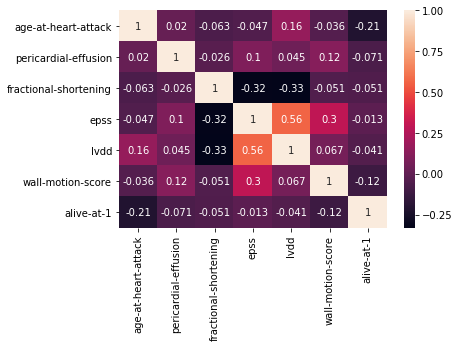

In [13]:
# Checking if there are highly correlated variables to remove
Var_Corr = df.corr()
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

#There are not, so everything is fine

# Final input data

In [14]:
df.describe()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,alive-at-1
count,97.000000,97.00000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,61.546392,0.14433,0.229175,11.042732,4.677959,13.556804,0.443299
std,7.828927,0.35325,0.107584,6.596594,0.807437,3.760446,0.499355
min,35.000000,0.00000,0.030000,0.000000,2.320000,2.000000,0.000000
25%,57.000000,0.00000,0.150000,6.800000,4.170000,11.000000,0.000000
50%,62.000000,0.00000,0.217000,10.000000,4.560000,13.500000,0.000000
75%,66.000000,0.00000,0.290000,13.200000,5.250000,15.000000,1.000000
max,81.000000,1.00000,0.610000,31.000000,6.780000,23.000000,1.000000


# Training model

In [15]:
from sklearn.metrics import auc, precision_recall_curve

Creating train test set

In [16]:
labels = df['alive-at-1']
features = df[['age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

Finding best model

In [17]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc', cv=StratifiedKFold())
clf.fit(X_train, y_train)
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 1.809140703517588, 'kernel': 'rbf'}


# Visualisation

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
model = deepcopy(my_svc)

In [20]:
y_pred = model.predict(X_test)

In [21]:
confusion_matrix(y_pred, y_test)

array([[14,  9],
       [ 4,  6]], dtype=int64)

In [22]:
precision, recall, thresholds = precision_recall_curve(y_pred, y_test)
auc(recall, precision)

0.5606060606060606

# Data normalisation

Normalisation without scaling

In [27]:
def normalise_column(df, col, scale=1):
    df[col]=((df[col]-df[col].min())/
               (df[col].max()-df[col].min())) * scale
    return df[col]

In [37]:
df_after_preprocessing = deepcopy(df) 

In [38]:
for i in ['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score']:
    df[i] = normalise_column(df, i, 1)

In [39]:
df.head()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,alive-at-1
0,0.782609,0.0,0.396552,0.290323,0.511211,0.571429,0.0
1,0.804348,0.0,0.603448,0.193548,0.399103,0.571429,0.0
2,0.434783,0.0,0.396552,0.129032,0.246637,0.571429,0.0
3,0.543478,0.0,0.384483,0.389097,0.511883,0.666667,0.0
4,0.478261,0.0,0.224138,0.709677,0.769058,0.761905,0.0


In [40]:
labels = df['alive-at-1']
features = df[['age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

In [41]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc', cv=StratifiedKFold())
clf.fit(X_train, y_train)
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 1.4575577889447235, 'kernel': 'linear'}


In [42]:
y_pred = my_svc.predict(X_test)

In [43]:
confusion_matrix(y_pred, y_test)

array([[18, 13],
       [ 0,  2]], dtype=int64)

In [44]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.7636363636363637

# Data standarisation

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
df = deepcopy(df_after_preprocessing)

In [47]:
df[['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score']] = \
StandardScaler().fit_transform(df[['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score']])

In [48]:
df.head()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,alive-at-1
0,1.213796,0.0,0.288006,-0.311273,-0.097052,0.118470,0.0
1,1.342191,0.0,1.409205,-0.768416,-0.719513,0.118470,0.0
2,-0.840524,0.0,0.288006,-1.073178,-1.566058,0.118470,0.0
3,-0.198549,0.0,0.222602,0.155317,-0.093318,0.653084,0.0
4,-0.583734,0.0,-0.646327,1.669678,1.334606,1.187699,0.0


In [49]:
labels = df['alive-at-1']
features = df[['age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score']]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

In [50]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc', cv=StratifiedKFold())
clf.fit(X_train, y_train)
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 1.9598190954773869, 'kernel': 'rbf'}


In [51]:
y_pred = my_svc.predict(X_test)

In [52]:
confusion_matrix(y_pred, y_test)

array([[11,  8],
       [ 7,  7]], dtype=int64)

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.6045454545454545

# PCA

# n_components = 6

In [94]:
from sklearn.decomposition import PCA


In [95]:
df = deepcopy(df_after_preprocessing)

In [96]:
def apply_PCA_for_columns(df, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(df)
    return pca.transform(df)

In [97]:
labels = df['alive-at-1']
features = df[['age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score']]

In [98]:
features = apply_PCA_for_columns(features, 6)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

In [100]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc', cv=StratifiedKFold())
clf.fit(X_train, y_train)
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 1.9598190954773869, 'kernel': 'rbf'}


In [101]:
y_pred = my_svc.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[15,  7],
       [ 3,  8]], dtype=int64)

In [102]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.7363636363636363

# n_components = 5

In [103]:
df = deepcopy(df_after_preprocessing)
labels = df['alive-at-1']
features = df[['age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss', 'lvdd', 'wall-motion-score']]

In [104]:
features = apply_PCA_for_columns(features, 5)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

In [106]:
parameters = {'kernel':('linear', 'rbf'), 'C': np.linspace(start = 0.001, stop = 2, num = 200)}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='roc_auc', cv=StratifiedKFold())
clf.fit(X_train, y_train)
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

Chosing params:  {'C': 1.9296834170854271, 'kernel': 'linear'}


In [107]:
y_pred = my_svc.predict(X_test)
confusion_matrix(y_pred, y_test)

array([[14,  9],
       [ 4,  6]], dtype=int64)

In [108]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc(recall, precision)

0.6363636363636365

# Predicting for discarded patients just out of curiosity

In [114]:
discarded_patients = original_df.iloc[rows_to_drop, [2, 3, 4, 5, 6, 7]]

Preprocessing for patients

In [115]:
discarded_patients = discarded_patients.replace(['?'], -1)
discarded_patients = discarded_patients.replace(pd.np.nan, -1)

# replacing missing values with median
for col_name in ['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score', 'pericardial-effusion']:
    imr = Imputer(missing_values=-1, strategy='median', axis=0)
    imr = imr.fit(df[[col_name]])
    discarded_patients[col_name] = imr.transform(discarded_patients[[col_name]]).ravel()
discarded_patients.describe()

,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,63.172878,0.285714,0.288463,13.055413,4.335060,15.771388
std,17.415880,0.458349,0.293671,8.974072,1.565342,8.034635
min,1.760870,0.000000,0.010000,0.000000,1.506726,1.642857
25%,61.000000,0.000000,0.135000,8.050000,4.050000,10.835000
50%,65.000000,0.000000,0.180000,12.200000,4.770000,15.000000
75%,72.000000,1.000000,0.260000,18.100000,5.355000,20.250000
max,86.000000,1.000000,0.967241,40.000000,6.730000,39.000000


In [116]:
for i in ['age-at-heart-attack', 'fractional-shortening', 'epss','lvdd', 'wall-motion-score']:
    discarded_patients[i] = normalise_column(discarded_patients, i, 1)

In [117]:
prediction_for_discarded_patients = model.predict(discarded_patients)

In [118]:
from collections import Counter
Counter(prediction_for_discarded_patients)

Counter({0.0: 35})

Sadly, according to my model every one of them will be dead at one year time from their heart attack.